In [109]:
#%%
%matplotlib inline
import pandas as pd
import plotly.plotly as py
import ast
import geopandas as gpd
import urllib2
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
min_max_scaler = preprocessing.MinMaxScaler()

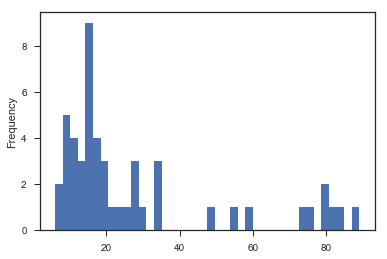

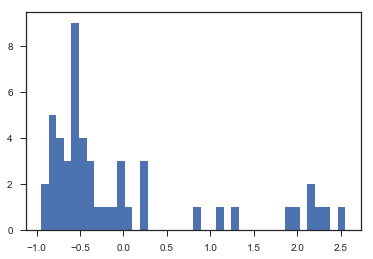

In [110]:
seleCol =  range(40,45)
seleCol.append(1)

####  read law scores
laws = pd.read_csv('laws.csv', delimiter=' ', header=None, usecols=seleCol)
laws.columns = ['state', 'total_score','curved_score','grade','2010_gun_death_rate','2009_gun_export_rates']
laws.set_index('state', inplace = True)
#laws.to_csv('laws_filter.csv')
laws = pd.read_csv('laws_filter.csv', delimiter=',')
laws.sort_values(laws.columns[0], ascending = True, inplace = True)
laws.reset_index(drop=True, inplace = True)
#read state code
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
laws['code']=df['code']
laws = laws[['code','state','curved_score']]

#sklearn.preprocessing.robust_scale(X, axis=0, with_centering=True, \
#with_scaling=True, quantile_range=(25.0, 75.0), copy=True)[source]¶
laws['curved_score'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(laws['curved_score']), bins=40)
plt.show()

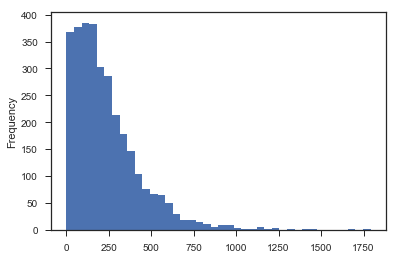

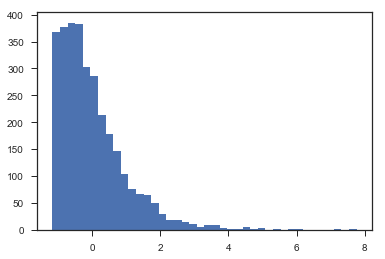

In [111]:
#### read crime rate
crime = pd.read_csv('crime_data_w_population_and_crime_rate.csv', 
                   usecols=[0, 1, 2, 21, 22, 23])
#create FIPS code by combining FIPSstate and FIPScity
crime['FIPStxt'] = pd.to_numeric(crime.FIPS_ST.apply(str)+
     crime.FIPS_CTY.apply(str).str.zfill(3))

crime['crime_rate_per_100000'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(crime['crime_rate_per_100000']), bins=40)
plt.show()
######

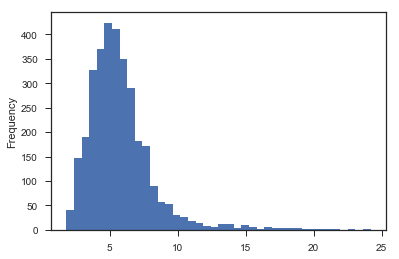

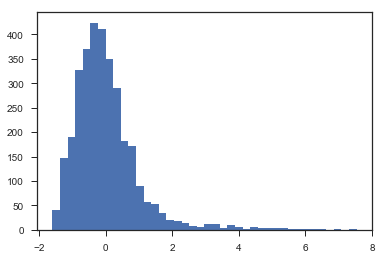

In [112]:
#### read 2015 unemployment rate and household income
#### No income data from PR
eco = pd.read_csv('Unemployment.csv',usecols=[0, 1, 2, 41, 46])
eco['Median_Household_Income_2015'] = eco['Median_Household_Income_2015'].str.replace(',','')
eco['Median_Household_Income_2015'] = pd.to_numeric(eco['Median_Household_Income_2015'])
eco['Median_Household_Income_2015'].fillna((eco['Median_Household_Income_2015'].mean()), inplace=True)
eco['Unemployment_rate_2015'].fillna((eco['Unemployment_rate_2015'].mean()), inplace=True)
eco['Unemployment_rate_2015'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(eco['Unemployment_rate_2015']), bins=40)
plt.show()
######

In [113]:
####containing 2015 Estimated percent of people of all ages
poverty = pd.read_csv('PovertyEstimates.csv',usecols=[0, 11])
#missing value'
poverty.rename(index=str, columns={'CI90LBALLP_2015':'poverty_rate'}, inplace=True)
poverty.ix[561,['poverty_rate']]=  0 
poverty['poverty_rate'] = pd.to_numeric(poverty['poverty_rate'])
#set missing value by median
poverty['poverty_rate'].fillna((poverty['poverty_rate'].mean()), inplace=True)
####

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [114]:

###Sources: Census Bureau,2011-2015 American Community Survey 5-yr average.
edu = pd.read_csv('Education.csv',usecols=[0, 45])
edu.rename(index=str, columns={'Percent of adults completing some college or associate\'s degree, 2011-2015':'college_rate'}, inplace=True)
edu['college_rate'].fillna((edu['college_rate'].mean()), inplace=True)
####

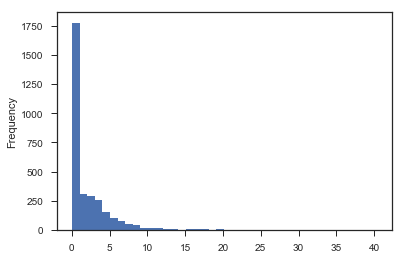

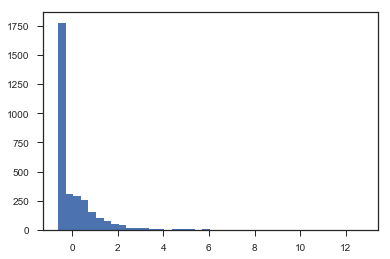

In [115]:
####cdc firearm death 1999-2015
fire = pd.read_csv('Underlying Cause of Death, 1999-2015.txt', 
                    delimiter='\t') 
fire['Deaths'] = pd.to_numeric(fire['Deaths'], errors='coerce')
fire['Population'] = pd.to_numeric(fire['Population'])
fire['fire_rate'] = 100000.0*fire['Deaths']/fire['Population']
#fill nan with 0
fire['fire_rate'] = fire['fire_rate'].fillna(value=0.0)
#round
fire['fire_rate'] = fire['fire_rate'].round(2)
fire['fire_rate'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(fire['fire_rate']), bins=40)
plt.show()
####

In [8]:
#normalize data
laws['curved_score'] = preprocessing.minmax_scale(laws['curved_score'])
eco['Unemployment_rate_2015'] = preprocessing.minmax_scale(eco['Unemployment_rate_2015'])
eco['Median_Household_Income_2015'] = preprocessing.minmax_scale(eco['Median_Household_Income_2015'])
crime['crime_rate_per_100000'] = preprocessing.minmax_scale(crime['crime_rate_per_100000'])
poverty['poverty_rate'] = preprocessing.minmax_scale(poverty['poverty_rate'])
edu['college_rate'] = preprocessing.minmax_scale(edu['college_rate'])
fire['fire_rate']  = preprocessing.minmax_scale(fire['fire_rate'] )

In [116]:
#merge to one dataframe
allData = pd.merge(eco, poverty, on='FIPStxt')
allData = pd.merge(allData, edu, left_on='FIPStxt', right_on='FIPS Code')
#allData = pd.merge(allData, crime, on='FIPStxt')
allData = pd.merge(allData, fire, left_on='FIPStxt', right_on='County Code')
allData = pd.merge(allData, laws, left_on='State', right_on='code')
allData = pd.merge(allData, crime, on='FIPStxt')
#allData FIPStxt code padding (add zero)
allData['FIPStxt'] = allData.FIPStxt.apply(str).str.zfill(5)

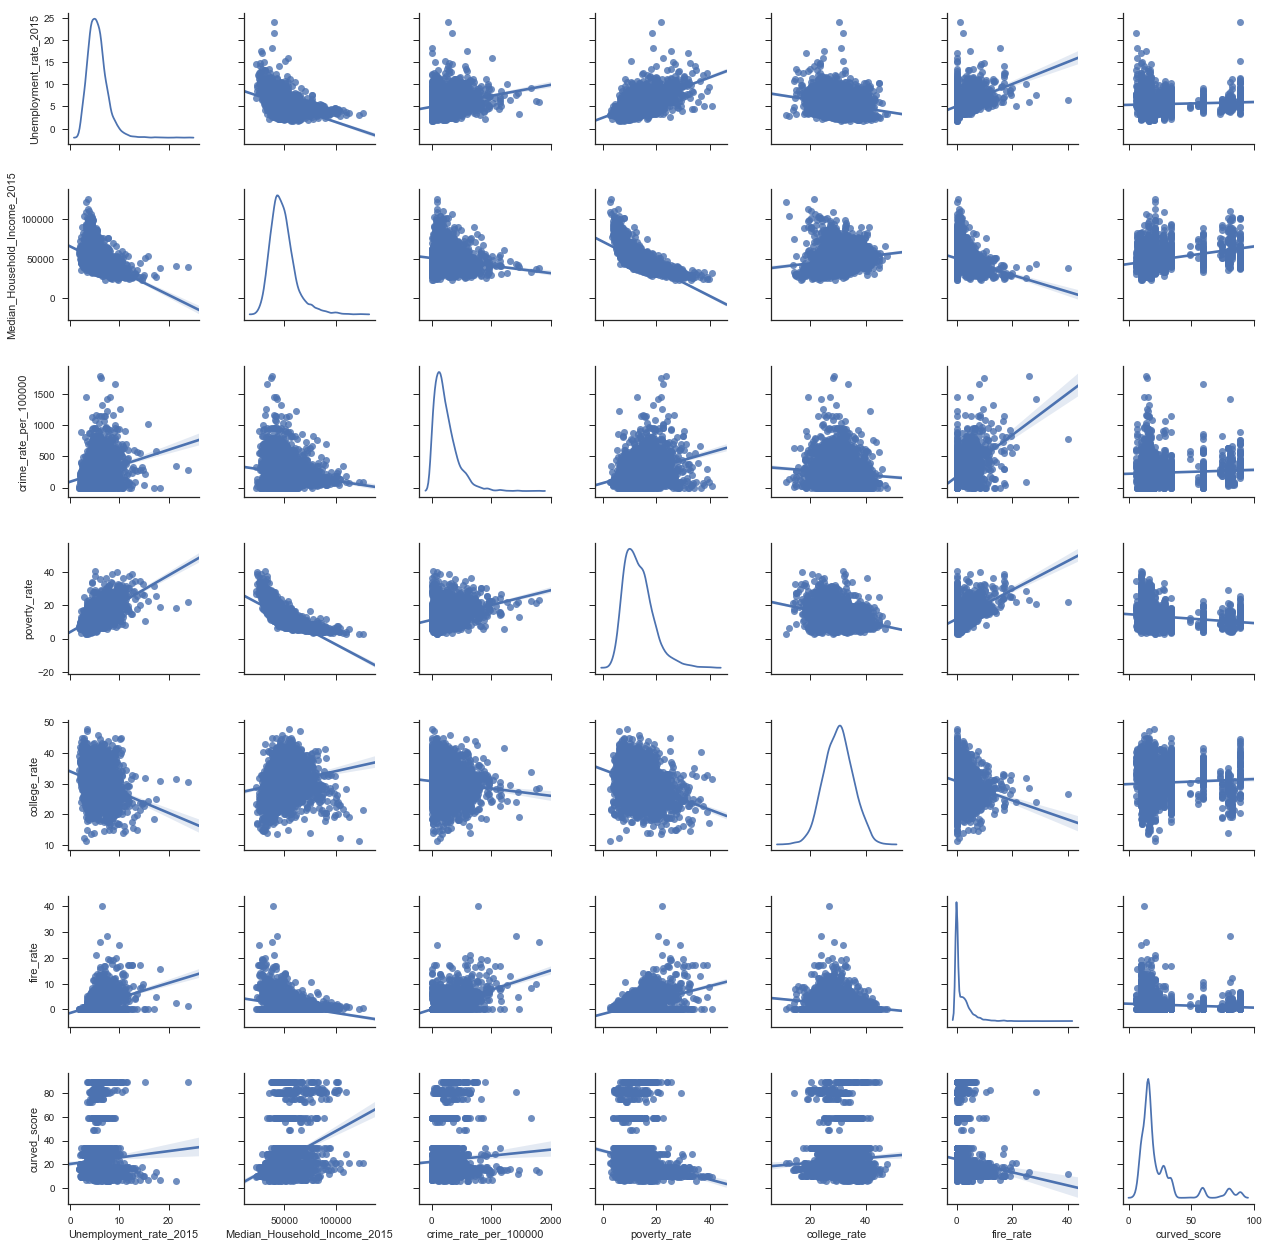

In [117]:
import seaborn as sns
#plot scatter, correlation 
sns.set(style="ticks")
sns.pairplot(allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
                      'poverty_rate','college_rate','fire_rate','curved_score']], diag_kind="kde", kind="reg")
plt.savefig('scatermatrix.eps', format='eps', dpi=600)
plt.show()

In [118]:
#write to file
allData.to_csv('allData_unnorm.csv')
allData.head(10)

,FIPStxt,State,Area_name,Unemployment_rate_2015,Median_Household_Income_2015,poverty_rate,FIPS Code,college_rate,Unnamed: 0,County,...,fire_rate,code,state,curved_score,county_name,crime_rate_per_100000,index,population,FIPS_ST,FIPS_CTY
0,01001,AL,"Autauga County, AL",5.3,56580.0,10.3,1001,30.4,NaN,"Autauga County, AL",...,2.66,AL,Alabama,17.5,"Autauga County, AL",251.601926,1136,55246,1,1
1,01003,AL,"Baldwin County, AL",5.6,52387.0,10.8,1003,31.8,NaN,"Baldwin County, AL",...,2.35,AL,Alabama,17.5,"Baldwin County, AL",228.086325,1298,195540,1,3
2,01005,AL,"Barbour County, AL",8.8,31433.0,27.1,1005,26.3,NaN,"Barbour County, AL",...,5.49,AL,Alabama,17.5,"Barbour County, AL",177.278771,1634,27076,1,5
3,01007,AL,"Bibb County, AL",6.7,40767.0,17.6,1007,27.9,NaN,"Bibb County, AL",...,6.40,AL,Alabama,17.5,"Bibb County, AL",217.661692,1352,22512,1,7
4,01009,AL,"Blount County, AL",5.4,50487.0,11.9,1009,32.2,NaN,"Blount County, AL",...,3.72,AL,Alabama,17.5,"Blount County, AL",210.810064,1384,57872,1,9
5,01011,AL,"Bullock County, AL",7.9,28251.0,32.1,1011,17.7,NaN,"Bullock County, AL",...,6.94,AL,Alabama,17.5,"Bullock County, AL",526.365260,267,10639,1,11
6,01013,AL,"Butler County, AL",7.6,33868.0,21.1,1013,25.6,NaN,"Butler County, AL",...,9.05,AL,Alabama,17.5,"Butler County, AL",537.873180,251,20265,1,13
7,01015,AL,"Calhoun County, AL",7.0,42091.0,17.5,1015,31.5,NaN,"Calhoun County, AL",...,7.81,AL,Alabama,17.5,"Calhoun County, AL",580.797697,189,116736,1,15
8,01017,AL,"Chambers County, AL",6.0,35560.0,18.5,1017,29.0,NaN,"Chambers County, AL",...,6.55,AL,Alabama,17.5,"Chambers County, AL",562.027984,212,34162,1,17
9,01019,AL,"Cherokee County, AL",5.4,39144.0,15.5,1019,29.3,NaN,"Cherokee County, AL",...,3.96,AL,Alabama,17.5,"Cherokee County, AL",415.982903,469,26203,1,19


In [12]:
##Do clustering 

##PCA first
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

In [13]:
data_cluster = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000','poverty_rate','college_rate']]
data_cluster.index = allData['Area_name']
data_cluster.head(10)

,Unemployment_rate_2015,Median_Household_Income_2015,crime_rate_per_100000,poverty_rate,college_rate
Area_name,,,,,
"Autauga County, AL",0.156250,0.327029,0.140403,0.252451,0.549223
"Baldwin County, AL",0.169643,0.286323,0.127281,0.264706,0.585492
"Barbour County, AL",0.312500,0.082898,0.098928,0.664216,0.443005
"Bibb County, AL",0.218750,0.173514,0.121463,0.431373,0.484456
"Blount County, AL",0.160714,0.267878,0.117640,0.291667,0.595855
"Bullock County, AL",0.272321,0.052007,0.293731,0.786765,0.220207
"Butler County, AL",0.258929,0.106537,0.300153,0.517157,0.424870
"Calhoun County, AL",0.232143,0.186368,0.324107,0.428922,0.577720
"Chambers County, AL",0.187500,0.122964,0.313632,0.453431,0.512953


In [14]:
pca = PCA(n_components=2)
pca.fit(data_cluster)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
data_cluster_2d = pca.transform(data_cluster)
data_cluster_2d = pd.DataFrame(data_cluster_2d)
data_cluster_2d.index = data_cluster.index
data_cluster_2d.columns = ['PC1','PC2']
data_cluster_2d.head()

,PC1,PC2
Area_name,,
"Autauga County, AL",-0.091324,0.033952
"Baldwin County, AL",-0.074754,-0.013110
"Barbour County, AL",0.385063,-0.025572
"Bibb County, AL",0.145251,0.010698
"Blount County, AL",-0.056730,-0.030998


In [16]:
print(pca.explained_variance_ratio_) 

[ 0.51098358  0.21809938]


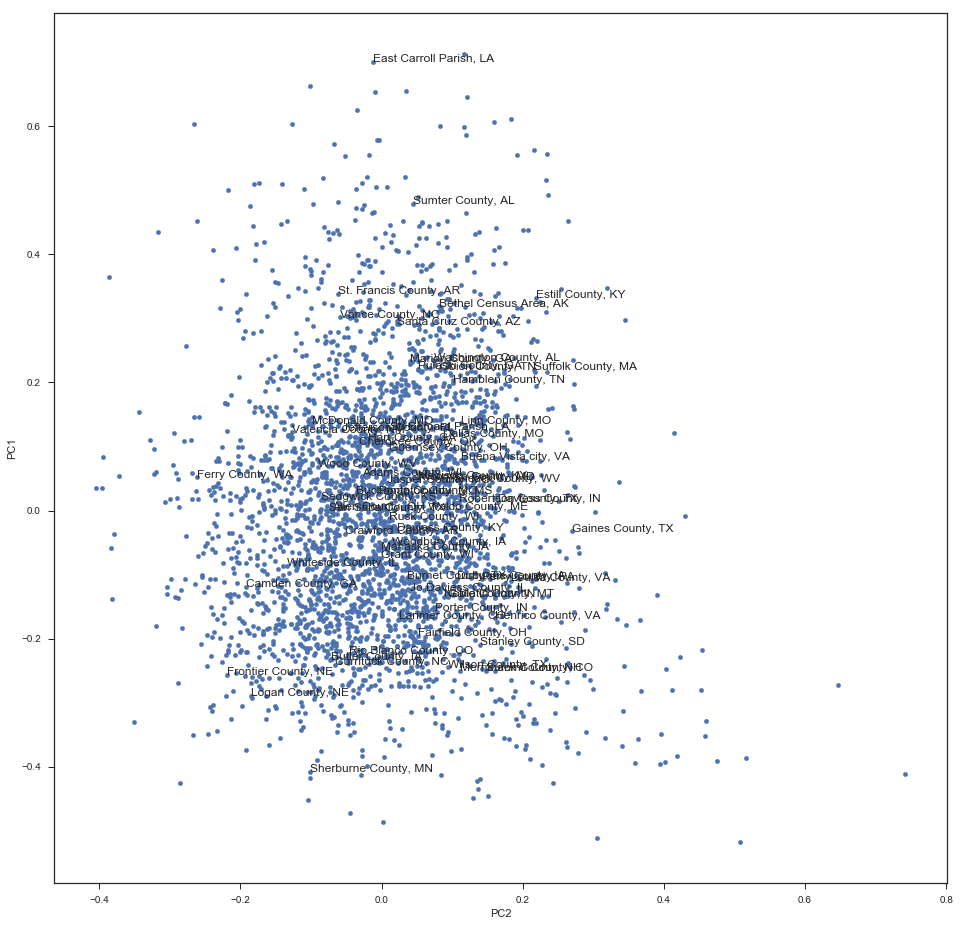

In [17]:
from random import *
ax = data_cluster_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,16))

for i, country in enumerate(data_cluster_2d.index):
    if randint(1,50) == 1:
        ax.annotate(country, (data_cluster_2d.iloc[i].PC2, data_cluster_2d.iloc[i].PC1))

In [18]:
from sklearn.cluster import KMeans
n_clusters=6
kmeans = KMeans(n_clusters)
clusters = kmeans.fit(data_cluster_2d)

data_cluster_2d['cluster'] = pd.Series(clusters.labels_, index=data_cluster_2d.index)
data_cluster_2d.head(10)
#data_cluster_2d.to_csv('all_PCA_cluster.csv')

,PC1,PC2,cluster
Area_name,,,
"Autauga County, AL",-0.091324,0.033952,2
"Baldwin County, AL",-0.074754,-0.013110,2
"Barbour County, AL",0.385063,-0.025572,3
"Bibb County, AL",0.145251,0.010698,4
"Blount County, AL",-0.056730,-0.030998,2
"Bullock County, AL",0.598700,0.117139,3
"Butler County, AL",0.314166,-0.003968,3
"Calhoun County, AL",0.154471,-0.104392,1
"Chambers County, AL",0.210689,-0.064495,3


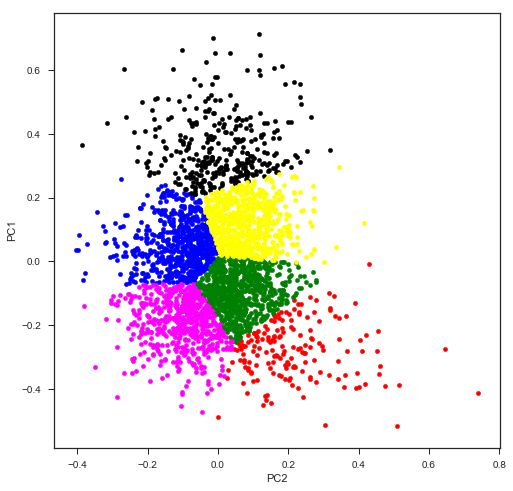

In [19]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'yellow', 5:'magenta'}
#data_cluster_2d['color'] = data_cluster_2d['cluster'].apply(lambda x: colors[x])
axk =data_cluster_2d.loc[data_cluster_2d['cluster']==0].plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=colors[0],
        figsize=(8,8))

for i in range(1, n_clusters):
    axk =data_cluster_2d.loc[data_cluster_2d['cluster']==i].plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=colors[i],
        figsize=(8,8),
        ax = axk)


In [20]:
##multi layer perceptron regression 

In [104]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

nn = MLPRegressor(hidden_layer_sizes=(100,100), activation='relu')
trainData = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
                      'poverty_rate','college_rate','curved_score']].values
targetData = allData['fire_rate'].values
kf = KFold(10)
scores = cross_val_score(nn, trainData, targetData, cv=10, scoring='r2')
print scores.mean()
nn.fit(X_train, y_train)

0.314168229205


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [105]:
nn.predict((0.2,0.1,0.2,0.5,0.6,0.5))

/Users/Xin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



array([ 0.08513122])

In [108]:
x_train = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
                      'poverty_rate','college_rate','curved_score']].values
print x_train

[[ 0.15625     0.32702949  0.14040322  0.25245098  0.5492228   0.13855422]
 [ 0.16964286  0.28632313  0.12728064  0.26470588  0.58549223  0.13855422]
 [ 0.3125      0.08289808  0.09892814  0.66421569  0.44300518  0.13855422]
 ..., 
 [ 0.14285714  0.3890453   0.01854296  0.18627451  0.64766839  0.03614458]
 [ 0.10714286  0.32225307  0.03296923  0.21078431  0.72020725  0.03614458]
 [ 0.07142857  0.3698037   0.03897996  0.18627451  0.73834197  0.03614458]]


In [ ]:
from sknn.mlp import Classifier, Layer 
X = [[0., 0.], [1., 1.]]  
y = [0, 1]  

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,  
                hidden_layer_sizes=(5, 2), random_state=1)  

clf.fit(X, y)  
print 'predict\t',clf.predict([[2., 2.], [-1., -2.]])  
print 'predict\t',clf.predict_proba([[2., 2.], [1., 2.]])  
print 'clf.coefs_ contains the weight matrices that constitute the model parameters:\t',[coef.shape for coef in clf.coefs_]  
print clf  
c=0  
for i in clf.coefs_:  
    c+=1  
    print c,len(i),i  